# Optimizing a newsvendor problem with JuMP

In [1]:
using JuMP, CairoMakie
import HiGHS

Let's use a simple newspaper example

In [2]:
newspaper_cost = 5
customer_price = 7

supply = 42
demand = 40

# Daily Profit is equal to the newspapers sold less the cost we paid for it
function profit(demand, supply, customer_price, newspaper_cost) 
    return (min.(demand, supply) .* customer_price) .- (newspaper_cost .* supply)
end

# one day
single_profit = profit(demand, supply, customer_price, newspaper_cost)
println("Our Profit for one day with supply $supply is: \$ $single_profit")

Our Profit for one day with supply 42 is: $ 70


Based on this model, we set a constant daily `supply` level and calculate the profit given uncertain, fluctuating demand. How will our strategy perform over 3 days, where one day we have demand that exceeds our supply and another day in which our demand is much less than supply?

In [3]:
# two days
three_day_demand = [40, 60, 25]
multi_day_profit = profit(three_day_demand, supply, customer_price, newspaper_cost)

println("Our Profit for three days with supply $supply is: \$ $sum(multi_day_profit)")

Our Profit for three days with supply 42 is: $ sum(multi_day_profit)


We see that with the cost and sales price assumptions in this model, there's a profit hit on day 3 that brings down the 3-day profit.

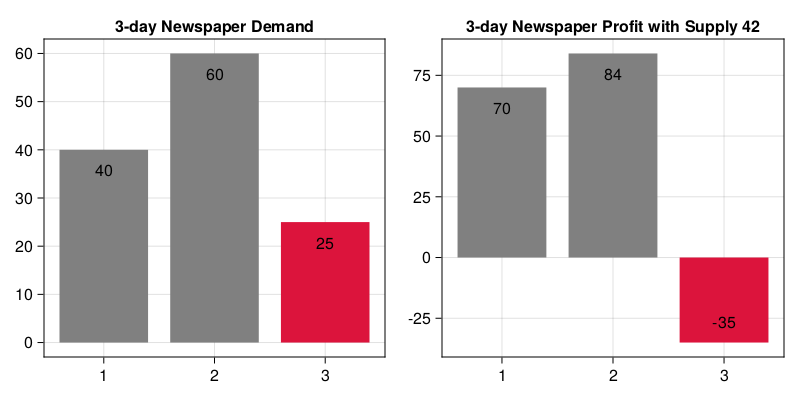

In [4]:
"""Plot Demand vs Profits"""
function plot_profit(demand, supply, profit; bar_labels=true)
        N = length(demand)
        fig = Figure(resolution=(800,400))

        ax1 = Axis(fig[1,1], title="$N-day Newspaper Demand")
        ax2 = Axis(fig[1,2], title="$N-day Newspaper Profit with Supply $supply")

        colors = [i >= 0 ? :grey : :crimson for i in profit]

        if bar_labels
                demand_labels = demand
                profit_labels = profit
        else
                demand_labels = ["" for i in demand]
                profit_labels = ["" for i in profit]
        end
        barplot!(ax1, demand, 
                bar_labels=demand_labels, 
                label_size=16,
                label_offset=-30,
                color=colors)
        barplot!(ax2, profit, 
                bar_labels=profit_labels, 
                label_size=16,
                label_offset=-30,
                color=colors)
        return fig
end

plot_profit(three_day_demand, supply, multi_day_profit)

## Finding the optimal supply level

For this example I'll use the Julia `JuMP` optimization library to find the optimal daily supply level $s$ that maximizes the total daily profit. Our first step is to convert this word problem into an optimization problem:

Let:

* $p$ = the customer price
* $d$ = demand
* $s$ = daily supply strategy
* $c$ = our newspaper cost

Then we want to maximize the sum of daily profits over $N$ days. If we have both price and cost as fixed, then we have: 

$$
\begin{aligned}
& \max \sum_i^N p* (\min(d,s)) - cs \\
&= \max \sum_i^N 7(\min(d,s)) - 5s
\end{aligned}
$$

Because $\min(d,s)$ is nonlinear, this can make finding an optimal solution a little difficult. Luckily, we have techniques to convert this problem into a linear one. [See this article on the Operations Research Stackexchange for more info.](https://or.stackexchange.com/questions/711/how-to-formulate-linearize-a-maximum-function-in-a-constraint/712#712)

First, let $x = \min(d,s)$. Then we can add some additional constraints and variables to convert this nonlinear optimization problem to a linear one:

$$
\begin{aligned}
\max & \sum_i^N 7x - 5s \\
\text{s.t.} & \\
x & \le d \\
x & \le i \\
x & \ge d - M(1-y) \\
x & \ge s - My \\
s & \ge 0 \\
y & \in \{0,1\}
\end{aligned}
$$

where $M$ is some reasonable solution. 

In [5]:
# 0. Params
demand = 40
M = 100

# 1. Establish model
model = Model(HiGHS.Optimizer)
# Option: To Suppress all the printing, use `set_silent(model)`
set_silent(model)

# 2. Variables
@variable(model, s >= 0, Int)
@variable(model, x >= 0)
@variable(model, y, Bin)

# 3. Constraints
# convert the min(d,i) nonlinear constraint to linear
@constraint(model, x <= demand)
@constraint(model, x <= s)
@constraint(model, x >= demand - M*(1-y))
@constraint(model, x >= s - M * y)

# 4. Objective Function
@objective(model, Max, (customer_price * x) - (newspaper_cost * s))

7 x - 5 s

In [6]:
# Optimize the model and print the value of $s$
optimize!(model)
value(s)

40.0

In [7]:
# What was the profit at this optimal value?
objective_value(model)

80.0

### Vectorizing in `JuMP` for multiple demand days

This code is starting to get a little messy, because of that $\min(d,s)$ constraint needs to be applied to each value of demand $d$ in an array.

To implement this in JuMP we'll need to *vectorize* the constraints and the variables.

In [8]:

"""Wrap the optimization problem within a function"""
function optimize_problem(demand)
    # 0. Params
    M = 100
    n = length(demand)

    # 1. Establish model
    model = Model(HiGHS.Optimizer)
    # Option: To Suppress all the printing, use `set_silent(model)`
    set_silent(model)

    # 2. Variables
    @variable(model, s >= 0, Int)
    @variable(model, x[i=1:n] >= 0) # Vectorize x 
    @variable(model, y[i=1:n], Bin) # Vectorize y too

    # 3. Constraints
    # convert the min(d,i) nonlinear constraint to linear
    @constraint(model, x .<= demand) 
    @constraint(model, x .<= s)
    @constraint(model, x .>= demand .- M .* (1 .- y))
    @constraint(model, x .>= s .- M .* y)

    # # 4. Objective Function
    @objective(model, Max, sum((customer_price .* x) .- (newspaper_cost .* s)))
    optimize!(model)

    return value(s)
end

optimize_problem

In [9]:
demand = [30, 30, 60, 25, 100]

optimal_supply = optimize_problem(demand)

30.0

Once again we can plot the daily profit:

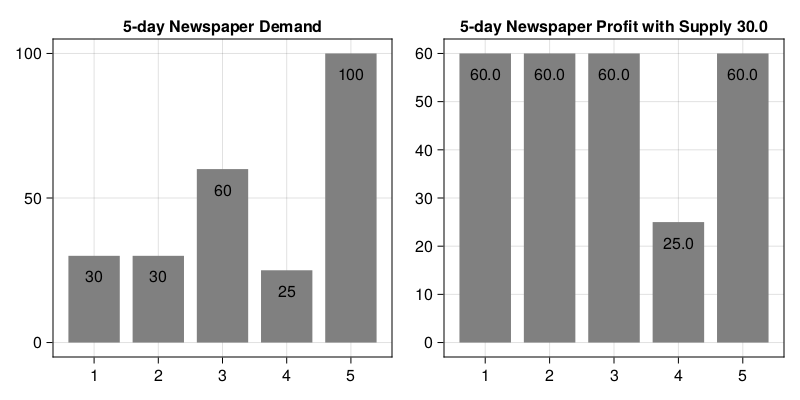

In [10]:
optimal_profits = profit(demand, optimal_supply, customer_price, newspaper_cost)

plot_profit(demand, optimal_supply, optimal_profits)

## What if demand is uncertain?

Optimizing over known demand is trivial - how would you set an optimal strategy when demand is unknown? 

We'll continue the example by randomly drawing from a demand model where demand $\sim \text{TruncatedNormal}(40, 10)$

In [11]:
using Random, Distributions

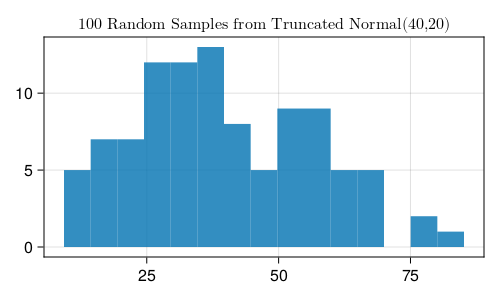

In [18]:
# set seed for reproducibility
Random.seed!(42)

# Specify the truncated distribution with truncated(dist, lower=0)
dist = truncated(Normal(40, 20), lower=0)
# Randomly sample 1000
sample_demand = rand(dist, 100)
# Plot
hist(sample_demand, 
     figure=(resolution=(500,300),),
     axis=(title=L"\text{100 Random Samples from Truncated Normal}(40,20)",))


In [19]:
random_sample_supply = optimize_problem(sample_demand)

29.0

Here our optimization problem selected a daily supply strategy of 29 newspapers. We again show the results below:

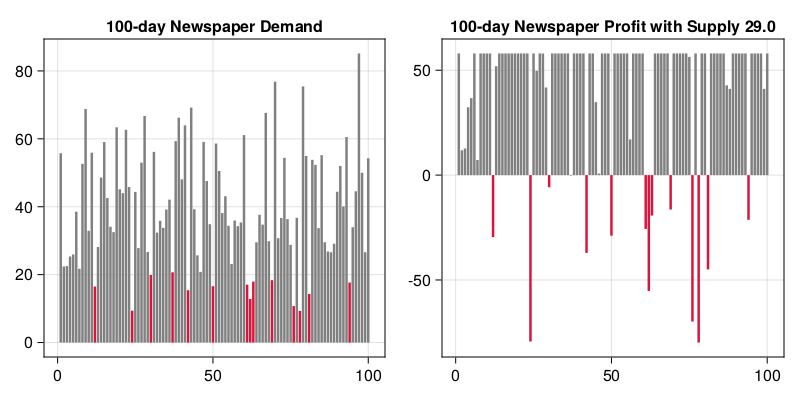

In [21]:
optimal_profits = profit(sample_demand, random_sample_supply, customer_price, newspaper_cost)

plot_profit(sample_demand, random_sample_supply, optimal_profits, bar_labels=false)

## Bayesian Statistics

How could we improve upon our assumption that demand is drawn from a $\text{TruncatedNormal}(40,20)$ distribution? If we had a few days of data we could improve upon our inventory strategy using Bayesian stats. 

Here we'll use `Turing`:

In [15]:
using Turing